In [53]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

In [54]:
# define paths
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
working_path = os.path.join(parent_dir) #incase directory needs to be expanded
downloads_path = os.path.expanduser("~\\Downloads")
extract_dir = os.path.expanduser("~\\Data_science")
data_path = os.path.join(parent_dir, 'Data')
train_data = os.path.join(data_path, 'train.csv')
test_data = os.path.join(data_path, 'test.csv')
sample_sub = os.path.join(data_path, 'sample_submission.csv')
final_sub = os.path.join(data_path, 'submission.csv')

In [55]:
train = pd.read_csv(train_data)
test = pd.read_csv(test_data)
sample_sub = pd.read_csv(sample_sub)

In [56]:
train.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


Defining the functions and classes for Pre-processing the data

In [57]:
def preprocess_text(text):
    #lowercase
    text = text.lower()
    #remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    #remove punctuation
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
    #remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [58]:
class TextStats(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return pd.DataFrame({
            'word_count': X.apply(lambda x: len(x.split())),
            'char_count': X.apply(len),
            'avg_word_length': X.apply(lambda x: np.mean([len(word) for word in x.split()]) if len(x.split()) > 0 else 0),
        })

In [59]:
class TextConcatenator(BaseEstimator, TransformerMixin):
    def __init__(self, col1, col2):
        self.col1 = col1
        self.col2 = col2
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.col1] + ' ' + X[self.col2]

Apply preprocessing to train and test data

In [60]:
for col in ['premise', 'hypothesis']:
    train[col] = train[col].apply(preprocess_text)
    test[col] = test[col].apply(preprocess_text)

Prepare TF-IDF features

In [61]:
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(train['premise'] + ' ' + train['hypothesis'])
X_sub_tfidf = tfidf.transform(test['premise'] + ' ' + test['hypothesis'])

Prepare data for RandomForestClassifier

In [62]:
X_train = X_train_tfidf
y_train = train['label']

Split train data for validation

In [63]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

In [64]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

In [65]:
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Use RandomizedSearchCV instead of GridSearchCV
rf_model = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(rf_model, param_dist, n_iter=10, cv=5, scoring='accuracy', n_jobs=-1)
random_search.fit(X_train, y_train)

best_rf_model = random_search.best_estimator_

In [66]:
y_val_pred = best_rf_model.predict(X_val)
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {accuracy}")

Validation Accuracy: 0.3655115511551155


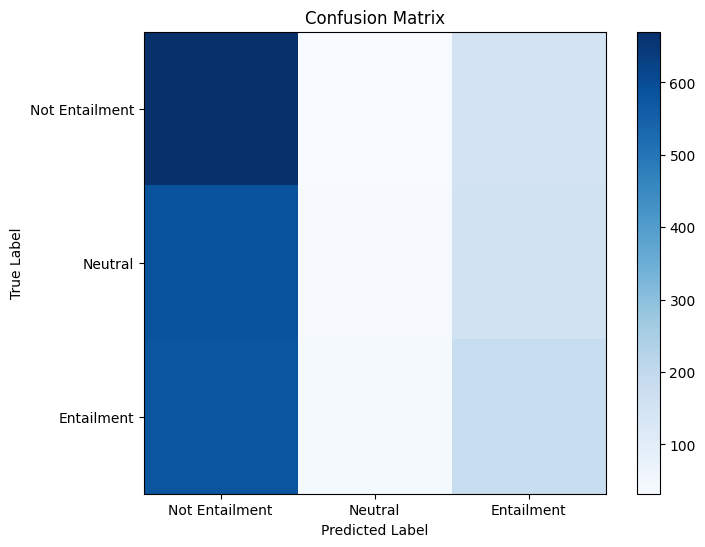

In [67]:
conf_matrix = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks([0, 1, 2], ['Not Entailment', 'Neutral', 'Entailment'])
plt.yticks([0, 1, 2], ['Not Entailment', 'Neutral', 'Entailment'])
plt.show()


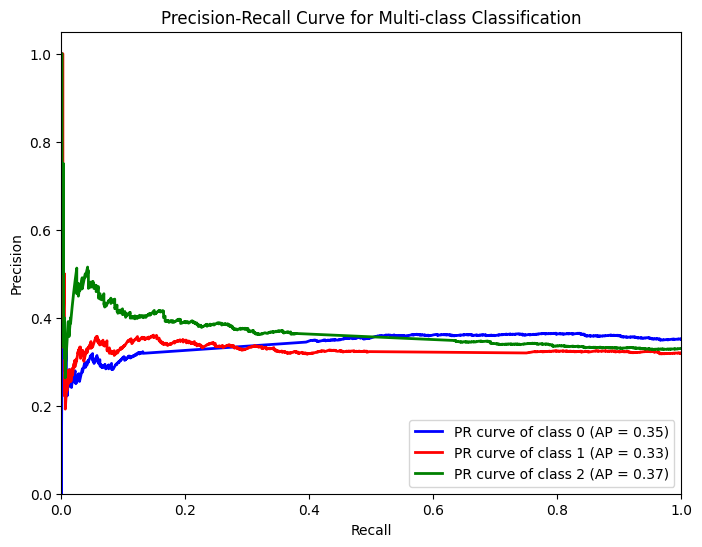

In [68]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Precision-Recall curve (for multi-class classification)
if len(np.unique(y_train)) > 2:
    y_val_prob = best_rf_model.predict_proba(X_val)
    n_classes = len(np.unique(y_train))
    
    # Compute Precision-Recall curve and area for each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_val == i, y_val_prob[:, i])
        average_precision[i] = average_precision_score(y_val == i, y_val_prob[:, i])

    # Plot Precision-Recall curve for each class
    plt.figure(figsize=(8, 6))
    colors = ['blue', 'red', 'green']  # You can add more colors if needed
    for i, color in zip(range(n_classes), colors):
        plt.plot(recall[i], precision[i], color=color, lw=2,
                 label='PR curve of class {0} (AP = {1:0.2f})'
                 ''.format(i, average_precision[i]))

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Multi-class Classification')
    plt.legend(loc="lower right")
    plt.show()
else:
    print("Precision-Recall curve is applicable only for multi-class classification.")

In [69]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
import keras_nlp
import keras
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [70]:
RESULT_DICT = {
    0 : "entailment",
    1 : "neutral",
    2 : "contradiction"
}

In [71]:
def display_pair_of_sentence(x):
    print( "Premise : " + x['premise'])
    print( "Hypothesis: " + x['hypothesis'])
    print( "Language: " + x['language'])
    print( "Label: " + str(x['label']))
    print()

train.head(10).apply(lambda x : display_pair_of_sentence(x), axis=1)

train.shape

Premise : and these comments were considered in formulating the interim rules
Hypothesis: the rules developed in the interim were put together with these comments in mind
Language: English
Label: 0

Premise : these are issues that we wrestle with in practice groups of law firms she said
Hypothesis: practice groups are not permitted to work on these issues
Language: English
Label: 2

Premise : des petites choses comme celles l font une diff rence norme dans ce que j essaye de faire
Hypothesis: j essayais d accomplir quelque chose
Language: French
Label: 0

Premise : you know they can t really defend themselves like somebody grown uh say my age you know yeah
Hypothesis: they can t defend themselves because of their age
Language: English
Label: 0

Premise : 
Hypothesis: 
Language: Thai
Label: 1

Premise : bir iftlikte birisinin a la kapat lm bu k zleri kesmeliyiz dedi ini duyabilirsiniz bu muhtemelen u anlama gelir y klenecek olanlar ay r n
Hypothesis: iftlikte insanlar farkl terimler kul

(12120, 6)

In [72]:
train.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,the rules developed in the interim were put to...,en,English,0
1,5b72532a0b,these are issues that we wrestle with in pract...,practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,des petites choses comme celles l font une dif...,j essayais d accomplir quelque chose,fr,French,0
3,5622f0c60b,you know they can t really defend themselves l...,they can t defend themselves because of their age,en,English,0
4,86aaa48b45,,,th,Thai,1


C:\Users\wfaiz\AppData\Local\Temp\ipykernel_98748\4108011066.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([RESULT_DICT[index] for index in abs_values.index])


Text(0.5, 1.0, 'Distribution of labels in the training set')

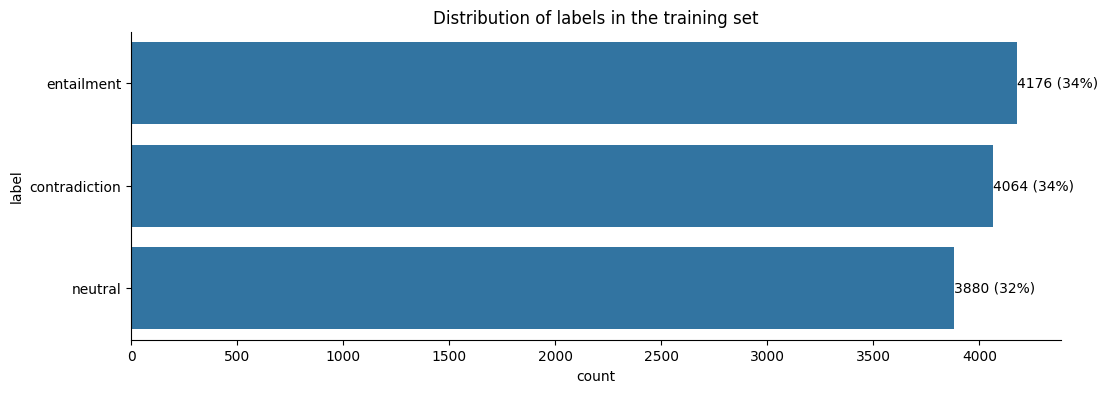

In [73]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(12, 4))

# Plot the total crashes
sns.set_color_codes("pastel")
sns.despine()
ax = sns.countplot(data=train, 
                   y="label",
                   order = train['label'].value_counts().index)

abs_values = train['label'].value_counts(ascending=False)
rel_values = train['label'].value_counts(ascending=False, normalize=True).values * 100
lbls = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values, rel_values)]

ax.bar_label(container=ax.containers[0], labels=lbls)

ax.set_yticklabels([RESULT_DICT[index] for index in abs_values.index])

ax.set_title("Distribution of labels in the training set")

Text(0.5, 1.0, 'Distribution of languages in the training set')

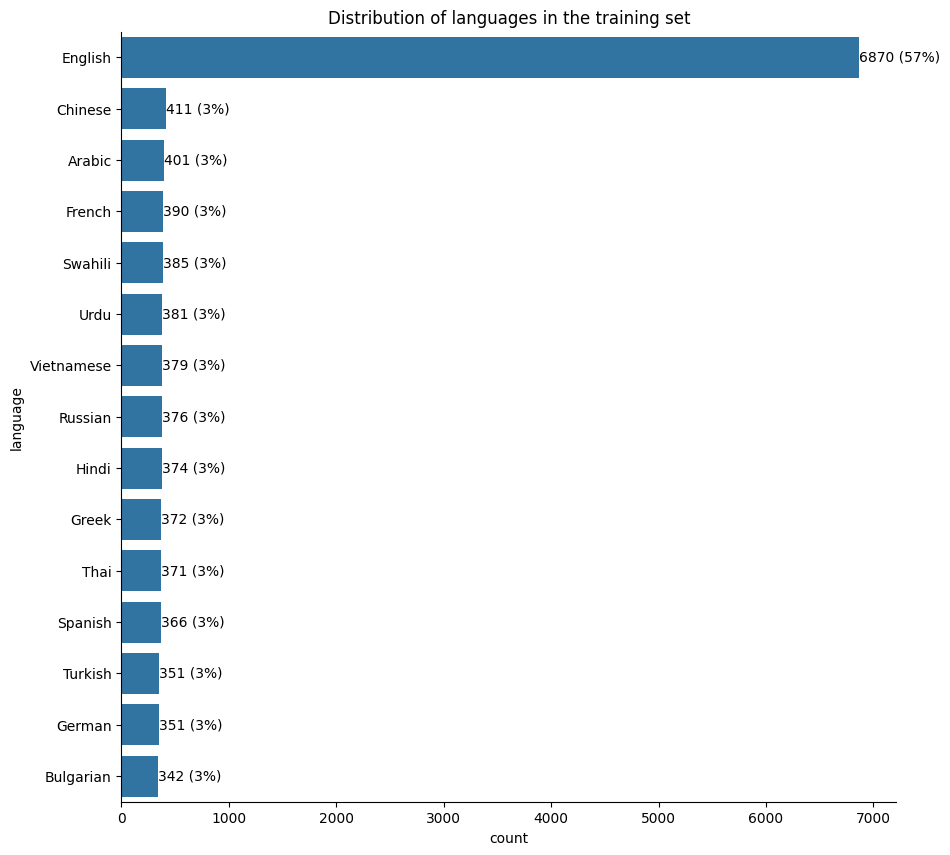

In [74]:
f, ax = plt.subplots(figsize=(10, 10))

# Plot the total crashes
sns.set_color_codes("pastel")
sns.despine()
ax = sns.countplot(data=train, 
                   y="language",
                   order = train['language'].value_counts().index)

abs_values = train['language'].value_counts(ascending=False)
rel_values = train['language'].value_counts(ascending=False, normalize=True).values * 100
lbls = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values, rel_values)]

ax.bar_label(container=ax.containers[0], labels=lbls)

ax.set_title("Distribution of languages in the training set")

In [75]:
train["premise_length"] = train["premise"].apply(lambda x : len(x))
train["hypothesis_length"] = train["hypothesis"].apply(lambda x : len(x))
train[["hypothesis_length", "premise_length"]].describe()

,hypothesis_length,premise_length
count,12120.000000,12120.000000
mean,41.385726,82.390594
std,31.625560,79.119534
min,0.000000,0.000000
25%,14.000000,16.000000
50%,42.000000,69.000000
75%,61.000000,127.000000
max,271.000000,967.000000


In [78]:
VALIDATION_SPLIT = 0.3
TRAIN_SIZE = int(train.shape[0]*(1-VALIDATION_SPLIT))
BATCH_SIZE = 16 #* strategy.num_replicas_in_sync
print(TRAIN_SIZE)

8484


In [90]:
from transformers import TFBertForSequenceClassification, BertTokenizer
import tensorflow as tf
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import os

In [85]:
# Disable symlinks warning
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"

model_name = "bert-base-multilingual-cased"

# Load the pre-trained BERT model and tokenizer
model = TFBertForSequenceClassification.from_pretrained(model_name, num_labels=3)
tokenizer = BertTokenizer.from_pretrained(model_name)

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  177853440 
                                                                 
 dropout_265 (Dropout)       multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
Total params: 177855747 (678.47 MB)
Trainable params: 177855747 (678.47 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [93]:
def tokenize_batch(premises, hypotheses, tokenizer, max_length=512):
    encodings = tokenizer(premises, hypotheses, truncation=True, padding=True, max_length=max_length, return_tensors='tf')
    return encodings['input_ids'], encodings['attention_mask']

# Tokenize the data
input_ids, attention_masks = tokenize_batch(train['premise'].tolist(), train['hypothesis'].tolist(), tokenizer)

# Convert labels to numpy array
labels = np.array(train['label'].tolist())

# Ensure consistency in data length
assert len(input_ids) == len(attention_masks) == len(labels), "Mismatch in the number of samples"

# Split the data
train_inputs, val_inputs, train_labels, val_labels = train_test_split(
    (input_ids, attention_masks), labels, test_size=VALIDATION_SPLIT, stratify=labels
)

ValueError: Found input variables with inconsistent numbers of samples: [2, 12120]

In [88]:
def split_labels(x, y):
    return (x[0], x[1]), y


training_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            train[['premise','hypothesis']].values,
            keras.utils.to_categorical(train['label'], num_classes=3)
        )
    )
)

train_dataset = training_dataset.take(TRAIN_SIZE)
val_dataset = training_dataset.skip(TRAIN_SIZE)

# Apply the preprocessor to every sample of train, val and test data using `map()`.
# [`tf.data.AUTOTUNE`](https://www.tensorflow.org/api_docs/python/tf/data/AUTOTUNE) and `prefetch()` are options to tune performance, see
# https://www.tensorflow.org/guide/data_performance for details.

train_preprocessed = train_dataset.map(split_labels, tf.data.AUTOTUNE).batch(BATCH_SIZE, drop_remainder=True).cache().prefetch(tf.data.AUTOTUNE)
val_preprocessed = val_dataset.map(split_labels, tf.data.AUTOTUNE).batch(BATCH_SIZE, drop_remainder=True).cache().prefetch(tf.data.AUTOTUNE)

In [89]:
EPOCHS=10
history = model.fit(train_preprocessed,
                         epochs=EPOCHS,
                         validation_data=val_preprocessed
                        )

Epoch 1/10


ValueError: in user code:

    File "C:\Users\wfaiz\AppData\Roaming\Python\Python312\site-packages\tf_keras\src\engine\training.py", line 1398, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\wfaiz\AppData\Roaming\Python\Python312\site-packages\tf_keras\src\engine\training.py", line 1381, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\wfaiz\AppData\Roaming\Python\Python312\site-packages\tf_keras\src\engine\training.py", line 1370, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\wfaiz\anaconda3\envs\NLI_proj\Lib\site-packages\transformers\modeling_tf_utils.py", line 1672, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\wfaiz\AppData\Roaming\Python\Python312\site-packages\tf_keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\wfaiz\AppData\Local\Temp\__autograph_generated_fileaf5hfsod.py", line 40, in tf__run_call_with_unpacked_inputs
        raise
    File "C:\Users\wfaiz\AppData\Local\Temp\__autograph_generated_filegi71w2nq.py", line 17, in tf__call
        outputs = ag__.converted_call(ag__.ld(self).bert, (), dict(input_ids=ag__.ld(input_ids), attention_mask=ag__.ld(attention_mask), token_type_ids=ag__.ld(token_type_ids), position_ids=ag__.ld(position_ids), head_mask=ag__.ld(head_mask), inputs_embeds=ag__.ld(inputs_embeds), output_attentions=ag__.ld(output_attentions), output_hidden_states=ag__.ld(output_hidden_states), return_dict=ag__.ld(return_dict), training=ag__.ld(training)), fscope)
    File "C:\Users\wfaiz\AppData\Local\Temp\__autograph_generated_fileaf5hfsod.py", line 40, in tf__run_call_with_unpacked_inputs
        raise
    File "C:\Users\wfaiz\AppData\Local\Temp\__autograph_generated_fileicohx16s.py", line 76, in tf__call
        batch_size, seq_length = ag__.ld(input_shape)

    ValueError: Exception encountered when calling layer 'tf_bert_for_sequence_classification_6' (type TFBertForSequenceClassification).
    
    in user code:
    
        File "c:\Users\wfaiz\anaconda3\envs\NLI_proj\Lib\site-packages\transformers\modeling_tf_utils.py", line 1734, in run_call_with_unpacked_inputs  *
            return func(self, **unpacked_inputs)
        File "c:\Users\wfaiz\anaconda3\envs\NLI_proj\Lib\site-packages\transformers\models\bert\modeling_tf_bert.py", line 1746, in call  *
            outputs = self.bert(
        File "C:\Users\wfaiz\AppData\Roaming\Python\Python312\site-packages\tf_keras\src\utils\traceback_utils.py", line 70, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
        File "C:\Users\wfaiz\AppData\Local\Temp\__autograph_generated_fileaf5hfsod.py", line 40, in tf__run_call_with_unpacked_inputs
            raise
        File "C:\Users\wfaiz\AppData\Local\Temp\__autograph_generated_fileicohx16s.py", line 76, in tf__call
            batch_size, seq_length = ag__.ld(input_shape)
    
        ValueError: Exception encountered when calling layer 'bert' (type TFBertMainLayer).
        
        in user code:
        
            File "c:\Users\wfaiz\anaconda3\envs\NLI_proj\Lib\site-packages\transformers\modeling_tf_utils.py", line 1734, in run_call_with_unpacked_inputs  *
                return func(self, **unpacked_inputs)
            File "c:\Users\wfaiz\anaconda3\envs\NLI_proj\Lib\site-packages\transformers\models\bert\modeling_tf_bert.py", line 873, in call  *
                batch_size, seq_length = input_shape
        
            ValueError: not enough values to unpack (expected 2, got 1)
        
        
        Call arguments received by layer 'bert' (type TFBertMainLayer):
          • input_ids=tf.Tensor(shape=(16,), dtype=string)
          • attention_mask=tf.Tensor(shape=(16,), dtype=string)
          • token_type_ids=None
          • position_ids=None
          • head_mask=None
          • inputs_embeds=None
          • encoder_hidden_states=None
          • encoder_attention_mask=None
          • past_key_values=None
          • use_cache=None
          • output_attentions=False
          • output_hidden_states=False
          • return_dict=True
          • training=True
    
    
    Call arguments received by layer 'tf_bert_for_sequence_classification_6' (type TFBertForSequenceClassification):
      • input_ids=('tf.Tensor(shape=(16,), dtype=string)', 'tf.Tensor(shape=(16,), dtype=string)')
      • attention_mask=None
      • token_type_ids=None
      • position_ids=None
      • head_mask=None
      • inputs_embeds=None
      • output_attentions=None
      • output_hidden_states=None
      • return_dict=None
      • labels=None
      • training=True


In [ ]:
predictions = model.predict((test['premise'],test['hypothesis']), batch_size=BATCH_SIZE)

In [ ]:
submission = test.id.copy().to_frame()
submission["prediction"] = np.argmax(predictions, axis=1)

submission

In [ ]:
submission.to_csv(final_sub, index=False)

In [46]:
import keras
import transformers
import tensorflow

print(f"keras version: {keras.__version__}")
print(f"transformers version: {transformers.__version__}")
print(f"tensorflow version: {tensorflow.__version__}")


keras version: 3.4.1.dev2024073003
transformers version: 4.43.3
tensorflow version: 2.18.0-dev20240725
